In [23]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
from astroplan import FixedTarget, Observer
from astropy.time import Time
import numpy as np

In [22]:
# altair = FixedTarget.from_name('Altair')
powell = Observer(latitude=38.64633*u.deg, longitude=-94.699973*u.deg, elevation=300*u.m, name="Powell Observatory", timezone="US/Central")
m42 = FixedTarget.from_name('M13')
powell.target_is_up(Time.now(), m42)

False

In [39]:
from datetime import datetime, timezone
from astropy.time import Time, TimeDelta, TimezoneInfo
now = datetime.now()
print(now)
t = Time(datetime.now())
print(t, t.format)
t2 = datetime(2024,2,19,13,50,0)
print(t2)
# convert datetime to utc
t3 = Time(t2, scale='utc')
print(t3)
nt = Time.now()
ut = Time(datetime.now(tz=timezone.utc), scale='utc')
print(nt, ut)

2024-02-19 13:57:26.022590
2024-02-19 13:57:26.022666 datetime
2024-02-19 13:50:00
2024-02-19 13:50:00
2024-02-19 19:57:26.023427 2024-02-19 19:57:26.023527


In [300]:
t_m42 = FixedTarget.from_name('M42')
t_m31 = FixedTarget.from_name('M31')
t_m13 = FixedTarget.from_name('M13')
t_m1 = FixedTarget.from_name('M1')
t_m16 = FixedTarget.from_name('M16')
polaris = FixedTarget.from_name('Polaris')
t_ring = FixedTarget.from_name('Ring Nebula')
t_m8 = FixedTarget.from_name('M8')
t_m101 = FixedTarget.from_name('M101')
t_dumbbell = FixedTarget.from_name('Dumbbell Nebula')
t_mizar = FixedTarget.from_name('Mizar')
# t_alcor = FixedTarget.from_name('Alcor')
t_bode = FixedTarget.from_name('Bode\'s Galaxy')
t_cigar = FixedTarget.from_name('Cigar Galaxy')
t_m51 = FixedTarget.from_name('M51')
t_m81 = FixedTarget.from_name('M81')
t_hamburger = FixedTarget.from_name('NGC 3628')
t_m82 = FixedTarget.from_name('M82')
t_fw = FixedTarget.from_name('NGC 6946')
t_leo = FixedTarget.from_name('Leo Triplet')
t_sombrero = FixedTarget.from_name('Sombrero Galaxy')
t_albireo = FixedTarget.from_name('Albireo')

targets = [t_m42, t_m31, t_m13, t_m1, t_m16, t_ring, t_m8, t_m101,
            t_dumbbell, t_mizar, t_bode, t_cigar, t_m51, t_m81, t_hamburger, t_m82, t_fw, t_leo, t_sombrero, t_albireo]
powell = Observer(latitude=38.64633*u.deg, longitude=-94.699973*u.deg, elevation=300*u.m, name="Powell Observatory", timezone="US/Central")
print(powell.location)

# sort the targets by ra, ascending
targets.sort(key=lambda x: x.ra.hour)

(-408721.31653067, -4971402.36351492, 3961916.27783899) m


In [254]:
from astroplan import (AltitudeConstraint, AirmassConstraint, 
                       AtNightConstraint, TimeConstraint, LocalTimeConstraint, time_grid_from_range, MissingConstraintWarning )
from astroplan import is_observable, is_always_observable, months_observable, observability_table
import pytz
import datetime as dt
import time
from astropy.time import Time, TimeDelta, TimezoneInfo

# code was cribbed from astroplan's github account, from  a proposed pull request

_current_year = time.localtime().tm_year  # needed for backward compatibility
_current_year_time_range = Time(  # needed for backward compatibility
    [str(_current_year) + '-01-01',
     str(_current_year) + '-12-31'])

def observable_interval(constraints, observer, targets,
                      time_range=_current_year_time_range,
                      time_grid_resolution=0.5*u.hour,
                      interval='months'):
    """
    Determines which weeks the specified ``targets`` are observable for a
    specific ``observer``, given the supplied ``constraints``. Generic version of
    `months_observable` that includes functionality for days and weeks.
    Parameters
    ----------
    constraints : list or `~astroplan.constraints.Constraint`
        Observational constraint(s)
    observer : `~astroplan.Observer`
        The observer who has constraints ``constraints``
    targets : {list, `~astropy.coordinates.SkyCoord`, `~astroplan.FixedTarget`}
        Target or list of targets
    time_range : `~astropy.time.Time` (optional)
        Lower and upper bounds on time sequence
        If ``time_range`` is not specified, defaults to current year (localtime)
    time_grid_resolution : `~astropy.units.Quantity` (optional)
        If ``time_range`` is specified, determine whether constraints are met
        between test times in ``time_range`` by checking constraint at
        linearly-spaced times separated by ``time_resolution``. Default is 0.5
        hours.
        
    interval : str (optional)
        Defines the interval of what dates to calculate ``constraints`` on.
        
    Returns
    -------
    observability : list
        List of sets of unique integers representing each interval that a target is
        observable, one set per target. These integers are 1-based so that
        January maps to 1, Feburary maps to 2, etc., and it is a similar structure
        for day and week intervals.
    """
    # TODO: This method could be sped up a lot by dropping to the trigonometric
    # altitude calculations.
    if not hasattr(constraints, '__len__'):
        constraints = [constraints]
    if interval not in ['days','weeks','months']:
        raise ValueError('interval is of an incorrect type. Please choose days, weeks, or months')

    times = time_grid_from_range(time_range, time_grid_resolution)

    # If the constraints don't include AltitudeConstraint or its subclasses,
    # warn the user that they may get months when the target is below the horizon
    altitude_constraint_supplied = any(
        [isinstance(constraint, AltitudeConstraint) for constraint in constraints]
    )
    if not altitude_constraint_supplied:
        message = ("observable_interval usually expects an AltitudeConstraint or "
                   "AirmassConstraint to ensure targets are above horizon.")
        print(message, MissingConstraintWarning)

    applied_constraints = [constraint(observer, targets,
                                      times=times,
                                      grid_times_targets=True)
                           for constraint in constraints]
    constraint_arr = np.logical_and.reduce(applied_constraints)


    observability = []

    method_dic = {'days':lambda t: t.datetime.timetuple().tm_yday,
                  'weeks':lambda t: t.datetime.isocalendar()[1],
                  'months':lambda t: t.datetime.month}


    for target, observable in zip(targets, constraint_arr):
        s = set([method_dic[interval](t) for t in times[observable]]) # type: ignore
        observability.append(s)

    return observability

In [313]:
from astroplan import (AltitudeConstraint, AirmassConstraint, 
                       AtNightConstraint, TimeConstraint, LocalTimeConstraint)
from astroplan import is_observable, is_always_observable, months_observable, observability_table
import pytz
import datetime as dt

print("dt at 20 = ", dt.time(20,00))

# looks like local constraints ONLY work with hours at UTC location!!
constraints = [  AltitudeConstraint(25*u.deg, 90*u.deg),\
                 AirmassConstraint(3),
                 # LocalTimeConstraint(min=dt.time(2,00,00, tzinfo=powell.timezone), max=dt.time(5,59,59, tzinfo=powell.timezone))]
                 # both of these work
                 LocalTimeConstraint(min=dt.time(2,00,00), max=dt.time(5,59,59))]

best_months = months_observable(constraints, powell, targets)
                                # time_range=Time(['2024-02-01', '2024-10-31'])) # a Time can be more than one time!
for i, months in enumerate(best_months):
    print(targets[i].name, months)


print("-------------------")

obs_interval = observable_interval(constraints, powell, targets,
            time_grid_resolution=0.5*u.hour, interval='weeks')
# for i, obs in enumerate(obs_interval):
#     print(targets[i].name, obs)

print("powell time zone = ", powell.timezone)
print("dt at 20 powell tz = ", dt.time(20,00,00, tzinfo=powell.timezone))
      
# print("best months = ", best_months)

is_obs = is_observable(constraints, powell, t_ring, times=Time.now())
is_obs_r = is_observable(constraints, powell, t_ring, time_range=(Time('2024-02-19 00:00:00'), Time('2024-11-19 23:59:59')))
print("is obs = ", is_obs)
print("is obs r = ", is_obs_r)

print (powell.target_is_up(Time.now(), t_m42))
rt = Time('2024-02-19')
local_tz = pytz.timezone('US/Central')
print ("rise local = ", powell.target_rise_time(time=rt, target=t_m42, which='next').to_datetime(timezone=local_tz)) # 2024-02-19 14:15:24.941486-06:00
print ("rise utc/iso = ", powell.target_rise_time(time=rt, target=t_m42, which='next').iso)                          # 2024-02-19 20:15:24.941
rises = powell.target_rise_time(time=rt, target=t_m42, which='next') # Time object
rises_dt = rises.to_datetime(timezone=local_tz) # Datetime object, with timezone
aslocal = rises_dt.astimezone(local_tz) # Datetime object, with timezone
print(rises_dt, aslocal) # both 2024-02-19 14:15:24.941486-06:00
print(datetime.strftime(aslocal, '%Y-%m-%d %H:%M:%S %Z%z')) #2024-02-19 14:15:24 CST-0600
print(datetime.strftime(aslocal, '%Y-%m-%d %H:%M:%S %Z'))  # 2024-02-19 14:15:24 CST

dt at 20 =  20:00:00
M31 {1, 2, 3, 7, 8, 9, 10, 11, 12}
M1 {1, 2, 3, 4, 5, 10, 11, 12}
M42 {1, 2, 3, 4, 11, 12}
Bode's Galaxy {1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12}
M81 {1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12}
Cigar Galaxy {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
M82 {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
Leo Triplet {1, 2, 3, 4, 5, 6, 7}
NGC 3628 {1, 2, 3, 4, 5, 6, 7}
Sombrero Galaxy {2, 3, 4, 5, 6, 7}
Mizar {1, 2, 3, 4, 5, 6, 7, 8, 9}
M51 {1, 2, 3, 4, 5, 6, 7, 8, 9}
M101 {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
M13 {3, 4, 5, 6, 7, 8, 9, 10}
M8 {8, 9, 6, 7}
M16 {5, 6, 7, 8, 9, 10}
Ring Nebula {4, 5, 6, 7, 8, 9, 10, 11, 12}
Albireo {5, 6, 7, 8, 9, 10, 11, 12}
Dumbbell Nebula {5, 6, 7, 8, 9, 10, 11, 12}
NGC 6946 {1, 4, 5, 6, 7, 8, 9, 10, 11, 12}
-------------------
powell time zone =  US/Central
dt at 20 powell tz =  20:00:00
is obs =  [False]
is obs r =  [ True]
True
rise local =  2024-02-19 14:15:24.941486-06:00
rise utc/iso =  2024-02-19 20:15:24.941
2024-02-19 14:15:24.941486-06:00 2024-02-19 14:1

In [214]:
# t_m42.coord.transform_to(AltAz(obstime=Time.now() - 6*u.hour, location=powell.location))
print(Time.now() - 6*u.hour)
print("m42 now ", powell.altaz( Time.now(), t_m42)) # input as utc, converts internally to local time of Observer

obs_time = powell.datetime_to_astropy_time(dt.datetime.now())
print("obs time ", obs_time)

# convert desired local time into utc and then the output gets converted back to local time of Observer
july_time = powell.datetime_to_astropy_time(dt.datetime(2024,7,1,20,0,0))
print("m42 at july time ", powell.altaz(july_time, t_m42)) # input as utc, converts internally to local time of Observer

# print("m42 7-1 ", powell.altaz(obs_time , t_m42)) #enter the utc time, converts to local time of Observer
# print("m42 7-1 ", powell.altaz(Time('2024-07-01 20:00:00') + 5*u.hour, t_m42)) #enter the utc time, converts to local time of Observer
# print("timezone = ", powell.timezone)

2024-02-19 18:27:20.313323
m42 now  <SkyCoord (AltAz: obstime=2024-02-20 00:27:20.314112, location=(-408721.31653067, -4971402.36351492, 3961916.27783899) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (149.49349196, 41.27847527)>
obs time  2024-02-20 00:27:20.318025
m42 at july time  <SkyCoord (AltAz: obstime=2024-07-02 01:00:00, location=(-408721.31653067, -4971402.36351492, 3961916.27783899) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (283.09099512, -24.10954047)>


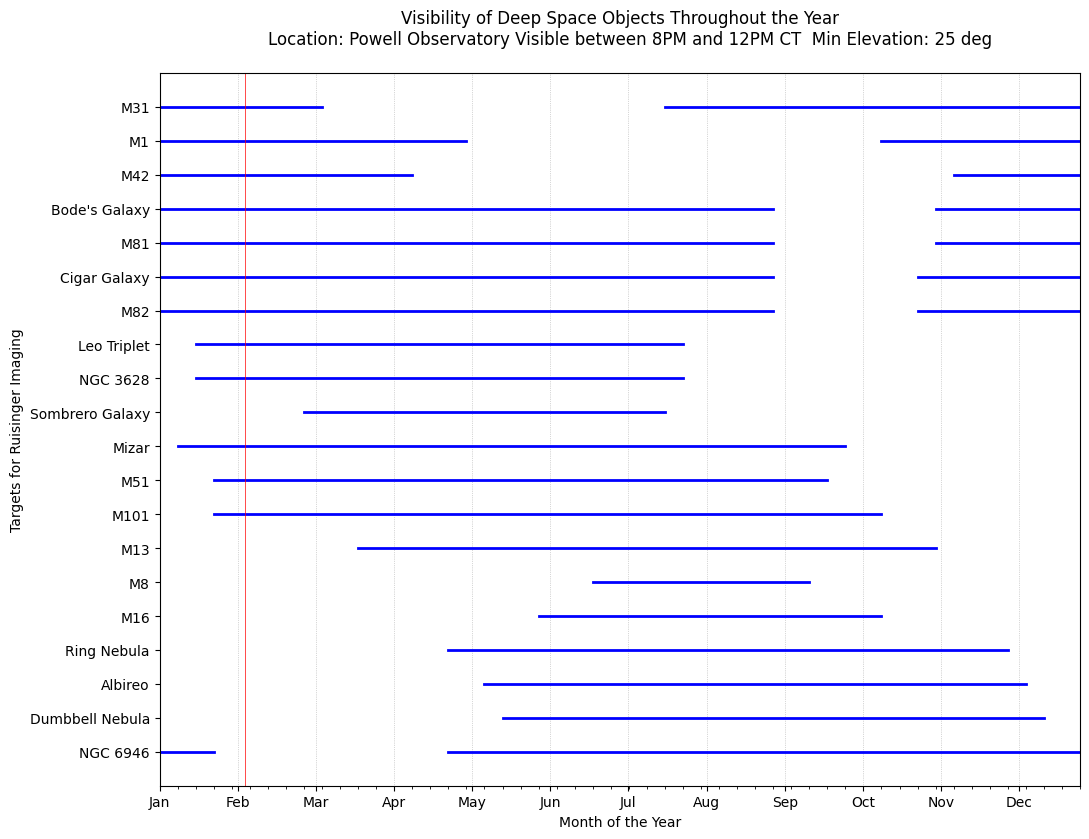

In [314]:
from datetime import datetime, timedelta

def convert_date_to_fractional_week(dt: datetime):
    """Converts a date to a fractional week.
    The fractional week is the number of weeks since the start of the year
    plus the fraction of the week that has passed. The start of the week is
    defined by the observer's timezone.
    """
    # Get the start of the week in the observer's timezone
    start_of_week = dt - dt.weekday() * timedelta(days=1)
    start_of_week = start_of_week.replace(hour=0, minute=0, second=0, microsecond=0)
    # Get the number of days since the start of the week
    days_since_start_of_week = (dt - start_of_week).total_seconds() / (24 * 3600)
    # Get the fractional week
    fractional_week = start_of_week.isocalendar()[1] + days_since_start_of_week / 7
    return fractional_week

# plot code with help from GPT
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np

# Assuming data has been loaded and adjusted so weeks start at 0
np.random.seed(0)
num_dso = len(obs_interval)
num_weeks = 52

data = np.zeros((num_dso, 52))

for i in range(num_dso):
    for week in obs_interval[i]:
        data[i, week-1] = 1

    # start_periods = np.sort(np.random.choice(range(0, 39), 2, replace=False))
    # for start in start_periods:
    #     duration = np.random.randint(3, 10)
    #     end = start + duration if start + duration <= 52 else 52
    #     data[i, start:end] = 1

# Plotting, now assuming weeks start at 0
fig, ax = plt.subplots(figsize=(11, 8.5))  # Landscape orientation

for i, row in enumerate(data):
    for j, visible in enumerate(row):
        if visible:
            if j == 0 or not row[j-1]:
                start = j
            if j == len(row)-1 or not row[j+1]:
                end = j
                ax.plot([start, end], [i, i], 'b', lw=2)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Assuming 4 weeks per month for labeling purposes
month_weeks = np.arange(0, 51, 4.33)

ax.set_xlim(0, 51)
ax.set_ylim(-1, 20)
ax.set_yticks(range(num_dso))
ax.set_yticklabels([f'{targets[i].name}' for i in range(num_dso)])
ax.set_xticks(month_weeks)
ax.set_xticklabels(months)
ax.set_xlabel('Month of the Year')
ax.set_ylabel('Targets for Ruisinger Imaging')
ax.set_title(
    f"""Visibility of Deep Space Objects Throughout the Year
    Location: {powell.name} Visible between 8PM and 12PM CT  Min Elevation: 25 deg
    """)
             
pn = convert_date_to_fractional_week(datetime(2024,2,3)) - 1

plt.axvline(x=pn, color='red', linewidth=0.5)

# Adding minor ticks for weeks
ax.xaxis.set_minor_locator(MultipleLocator(1))
plt.grid(True, which='major', axis='x', linestyle=':', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()